# Analyse Olmo:7b results

In this script I want to visualise some results from preliminary data I have of a corpus generated by models from the Olmo:7b family.
I have 5 generations per prompt, for 50 prompts, per model (`base`, `sft`, `dpo`, `rlvr`). 

Summary of processing steps:
* flatten the entropy analysis column into separate columns,
* concatenate original run with `temp=0.7` with all other temp runs
* remove preamble from Instruct-responses
* find out gender referenced in each response

## Load data into dataframe

In [1]:
import json
import pandas as pd
from pathlib import Path
from tqdm import tqdm

root_dir = Path.cwd().parent
data_dir = root_dir / "data" / "olmo7b_results"
OLMO_FILE = data_dir / "olmo7b_all_temps.jsonl"

# Load the data
olmo_df = pd.read_json(OLMO_FILE, lines=True)

# Display basic info
print(f"Shape: {olmo_df.shape}")
print(f"\nColumns: {olmo_df.columns.tolist()}")
print(f"\nFirst few rows:")
olmo_df.head()

Shape: (5999, 10)

Columns: ['model_key', 'model_name', 'profile_id', 'response_number', 'response', 'temperature', 'entropy_mean_entropy', 'entropy_max_entropy', 'entropy_min_entropy', 'entropy_std_entropy']

First few rows:


,model_key,model_name,profile_id,response_number,response,temperature,entropy_mean_entropy,entropy_max_entropy,entropy_min_entropy,entropy_std_entropy
0,base,allenai/Olmo-3-1025-7B,1,1,"[gender], their name is [name]. This narrativ...",0.7,0.839428,3.03125,3.408641e-07,0.742685
1,base,allenai/Olmo-3-1025-7B,1,2,"female, her name is [name], and she is a 30-y...",0.7,0.729715,2.93750,2.682209e-07,0.705402
2,base,allenai/Olmo-3-1025-7B,1,3,"female, [Gender: Female], [Education Level: L...",0.7,0.852306,2.90625,1.430511e-06,0.720453
3,base,allenai/Olmo-3-1025-7B,1,4,"male and naming him as John, the following na...",0.7,0.979604,3.65625,7.338822e-07,0.789281
4,base,allenai/Olmo-3-1025-7B,1,5,"female, her name is Sofia, and she is a low-e...",0.7,0.781961,2.62500,5.140901e-07,0.661650


## Entropy Distribution by Model Type, per temperature

Available temperatures: ['0.3', '0.5', '0.7', '1.0', '1.2', '1.5']
Model types: ['base', 'sft', 'dpo', 'rlvr']

Low temperatures (< 1.0): ['0.3', '0.5', '0.7']
High temperatures (>= 1.0): ['1.0', '1.2', '1.5']


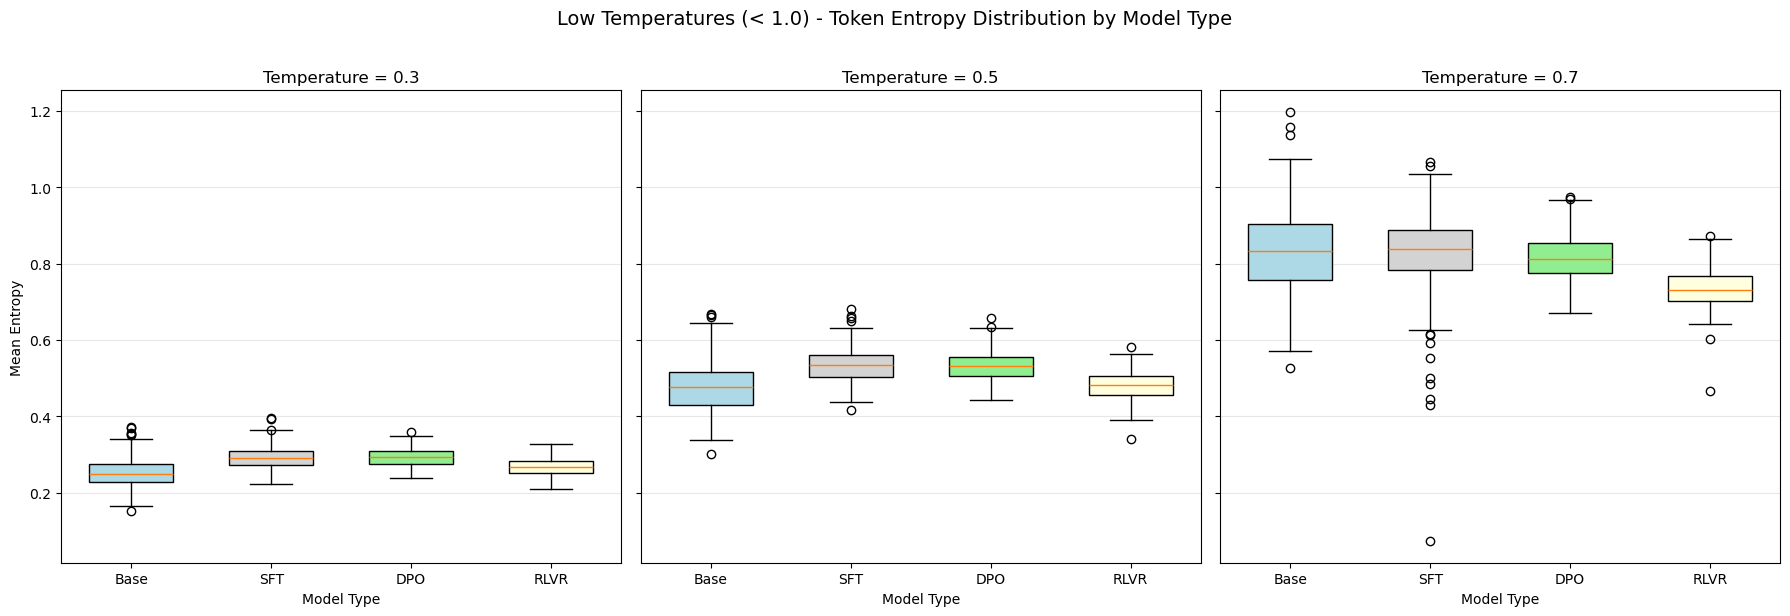

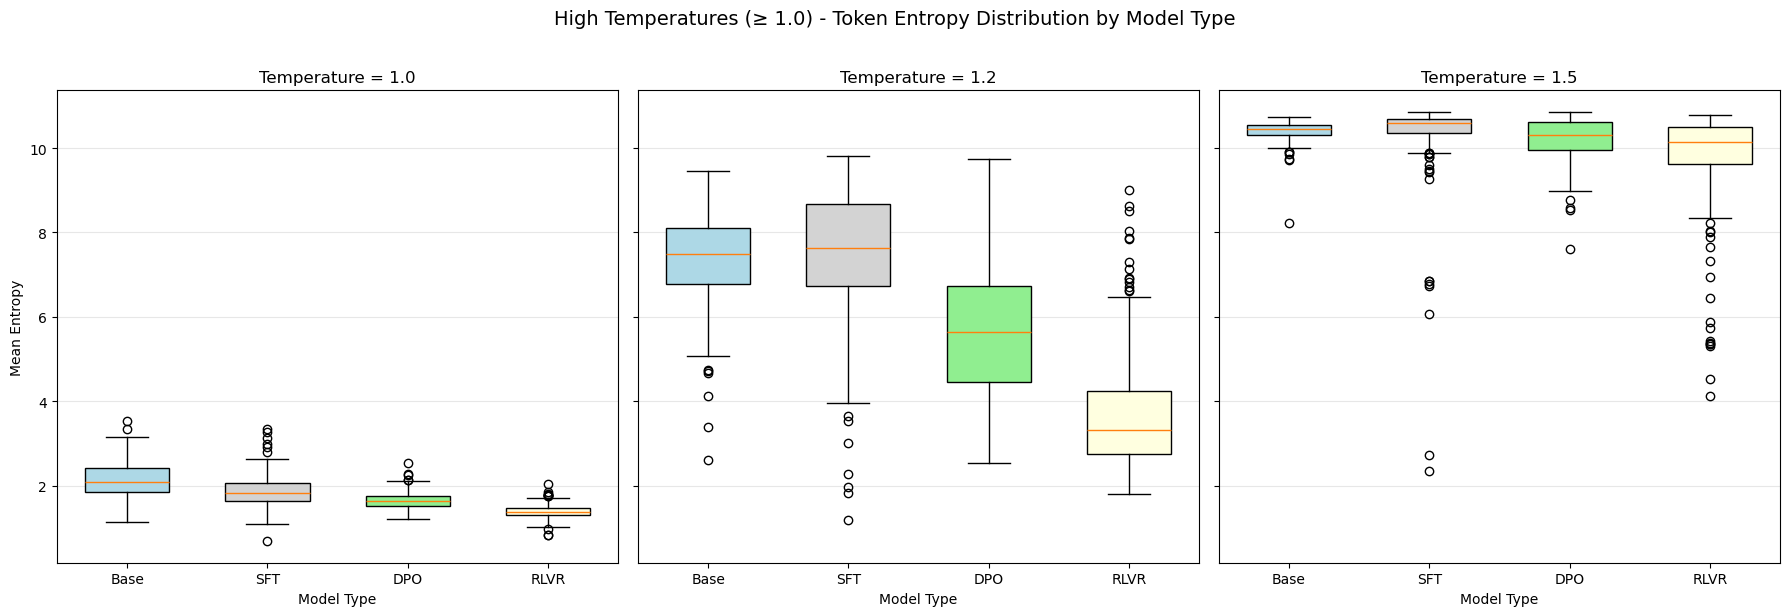


Statistics by Temperature and Model:

Temperature: 0.3
BASE  : n= 249, mean=0.2527, std=0.0375, min=0.1529, max=0.3714
SFT   : n= 250, mean=0.2918, std=0.0290, min=0.2235, max=0.3953
DPO   : n= 250, mean=0.2929, std=0.0229, min=0.2381, max=0.3592
RLVR  : n= 250, mean=0.2674, std=0.0225, min=0.2094, max=0.3285

Temperature: 0.5
BASE  : n= 250, mean=0.4768, std=0.0650, min=0.3013, max=0.6678
SFT   : n= 250, mean=0.5355, std=0.0434, min=0.4174, max=0.6799
DPO   : n= 250, mean=0.5306, std=0.0382, min=0.4432, max=0.6569
RLVR  : n= 250, mean=0.4804, std=0.0344, min=0.3396, max=0.5823

Temperature: 0.7
BASE  : n= 250, mean=0.8312, std=0.1130, min=0.5261, max=1.1973
SFT   : n= 250, mean=0.8269, std=0.1080, min=0.0732, max=1.0664
DPO   : n= 250, mean=0.8166, std=0.0578, min=0.6700, max=0.9749
RLVR  : n= 250, mean=0.7356, std=0.0499, min=0.4675, max=0.8717

Temperature: 1.0
BASE  : n= 250, mean=2.1528, std=0.4072, min=1.1418, max=3.5307
SFT   : n= 250, mean=1.8585, std=0.3582, min=0.6795, max=3

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique temperatures and sort them
temperatures = sorted(olmo_df['temperature'].unique())
model_types = ['base', 'sft', 'dpo', 'rlvr']

print(f"Available temperatures: {[f'{temp:.1f}' for temp in temperatures]}")
print(f"Model types: {model_types}")

# Split temperatures into two groups
low_temps = [t for t in temperatures if t < 1.0]
high_temps = [t for t in temperatures if t >= 1.0]

print(f"\nLow temperatures (< 1.0): {[f'{t:.1f}' for t in low_temps]}")
print(f"High temperatures (>= 1.0): {[f'{t:.1f}' for t in high_temps]}")

colors = ['lightblue', 'lightgrey', 'lightgreen', 'lightyellow']

# Function to create plot for a temperature group
def plot_temperature_group(temps, title_prefix):
    n_temps = len(temps)
    fig, axes = plt.subplots(1, n_temps, figsize=(6*n_temps, 6), sharey=True)
    
    # If only one temperature, make sure axes is iterable
    if n_temps == 1:
        axes = [axes]
    
    for temp_idx, temp in enumerate(temps):
        ax = axes[temp_idx]
        
        # Filter data for this temperature
        temp_data = olmo_df[olmo_df['temperature'] == temp]
        
        # Collect entropy data for each model
        entropy_by_model = []
        for model in model_types:
            model_data = temp_data[temp_data['model_key'] == model]
            entropy_by_model.append(model_data['entropy_mean_entropy'].tolist())
        
        # Create box plot
        positions = list(range(len(model_types)))
        bp = ax.boxplot(entropy_by_model, positions=positions, widths=0.6, patch_artist=True)
        
        # Color each box
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        
        ax.set_xlabel('Model Type')
        if temp_idx == 0:
            ax.set_ylabel('Mean Entropy')
        ax.set_title(f'Temperature = {temp:.1f}')
        ax.set_xticks(positions)
        ax.set_xticklabels(['Base', 'SFT', 'DPO', 'RLVR'])
        ax.grid(axis='y', alpha=0.3)
    
    plt.suptitle(f'{title_prefix} - Token Entropy Distribution by Model Type', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# Plot low temperatures
plot_temperature_group(low_temps, 'Low Temperatures (< 1.0)')

# Plot high temperatures
plot_temperature_group(high_temps, 'High Temperatures (≥ 1.0)')

# Print statistics for each temperature and model
print("\nStatistics by Temperature and Model:")
for temp in temperatures:
    print(f"\n{'='*60}")
    print(f"Temperature: {temp:.1f}")
    print(f"{'='*60}")
    temp_data = olmo_df[olmo_df['temperature'] == temp]
    
    for model_key in model_types:
        model_data = temp_data[temp_data['model_key'] == model_key]
        entropies = model_data['entropy_mean_entropy']
        
        if len(entropies) > 0:
            print(f"{model_key.upper():6s}: n={len(entropies):4d}, mean={entropies.mean():.4f}, "
                  f"std={entropies.std():.4f}, min={entropies.min():.4f}, max={entropies.max():.4f}")
        else:
            print(f"{model_key.upper():6s}: No data")

## Diversity (self-BLEU)

I am expecting to see, broadly, a negative correlation between self-BLEU diversity and the mean token-level entropy values.
This is because a lower self-BLEU score implies more varied vocabulary use when temperatures are increased, and therefore also I expect `base` model responses to often have the lowest scores across all models.

In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Download required NLTK data if needed
try:
    word_tokenize("test")
except LookupError:
    nltk.download('punkt')

def self_bleu(responses: list[str]) -> float:
    """
    Calculate self-BLEU across responses.
    
    Args:
        responses: List of response texts
    
    Returns:
        avg self-BLEU score (0-1, lower = more diverse)
    """
    if len(responses) < 2:
        return 0.0
    
    smoothing = SmoothingFunction()
    scores = []
    
    for i, response in enumerate(responses):
        hypothesis = word_tokenize(response.lower())
        references = [
            word_tokenize(responses[j].lower()) 
            for j in range(len(responses)) if j != i
        ]
        
        score = sentence_bleu(
            references,
            hypothesis,
            smoothing_function=smoothing.method1
        )
        scores.append(score)
    
    return sum(scores) / len(scores)

print("Self-BLEU function loaded")

Self-BLEU function loaded


In [4]:
# Compute self-BLEU for each profile_id, model, and temperature combination
from tqdm import tqdm

results = []

# Group by profile_id, model_key, and temperature
grouped = olmo_df.groupby(['profile_id', 'model_key', 'temperature'])

for (profile_id, model_key, temp), group in tqdm(grouped, desc="Computing self-BLEU"):
    responses = group['response'].tolist()
    
    if len(responses) >= 2:
        bleu_score = self_bleu(responses)
        results.append({
            'profile_id': profile_id,
            'model_key': model_key,
            'temperature': temp,
            'self_bleu': bleu_score,
            'n_responses': len(responses)
        })

# Create DataFrame with results
bleu_df = pd.DataFrame(results)

print(f"\nComputed self-BLEU for {len(results)} combinations")
print(f"\nSummary statistics:")
print(bleu_df.groupby(['model_key', 'temperature'])['self_bleu'].describe())

Computing self-BLEU: 100%|██████████| 1200/1200 [00:41<00:00, 29.08it/s]


Computed self-BLEU for 1200 combinations

Summary statistics:
                       count      mean       std       min       25%  \
model_key temperature                                                  
base      0.3           50.0  0.270345  0.051132  0.161684  0.238837   
          0.5           50.0  0.210086  0.037155  0.123419  0.181395   
          0.7           50.0  0.144027  0.037818  0.073805  0.119712   
          1.0           50.0  0.054737  0.020161  0.015751  0.039588   
          1.2           50.0  0.009440  0.006334  0.003520  0.005098   
          1.5           50.0  0.012066  0.016866  0.002235  0.004087   
dpo       0.3           50.0  0.259987  0.039376  0.182686  0.226925   
          0.5           50.0  0.207075  0.027295  0.149058  0.190602   
          0.7           50.0  0.168123  0.026582  0.107627  0.152889   
          1.0           50.0  0.105598  0.020519  0.067843  0.091123   
          1.2           50.0  0.052973  0.012473  0.025320  0.046419   
 

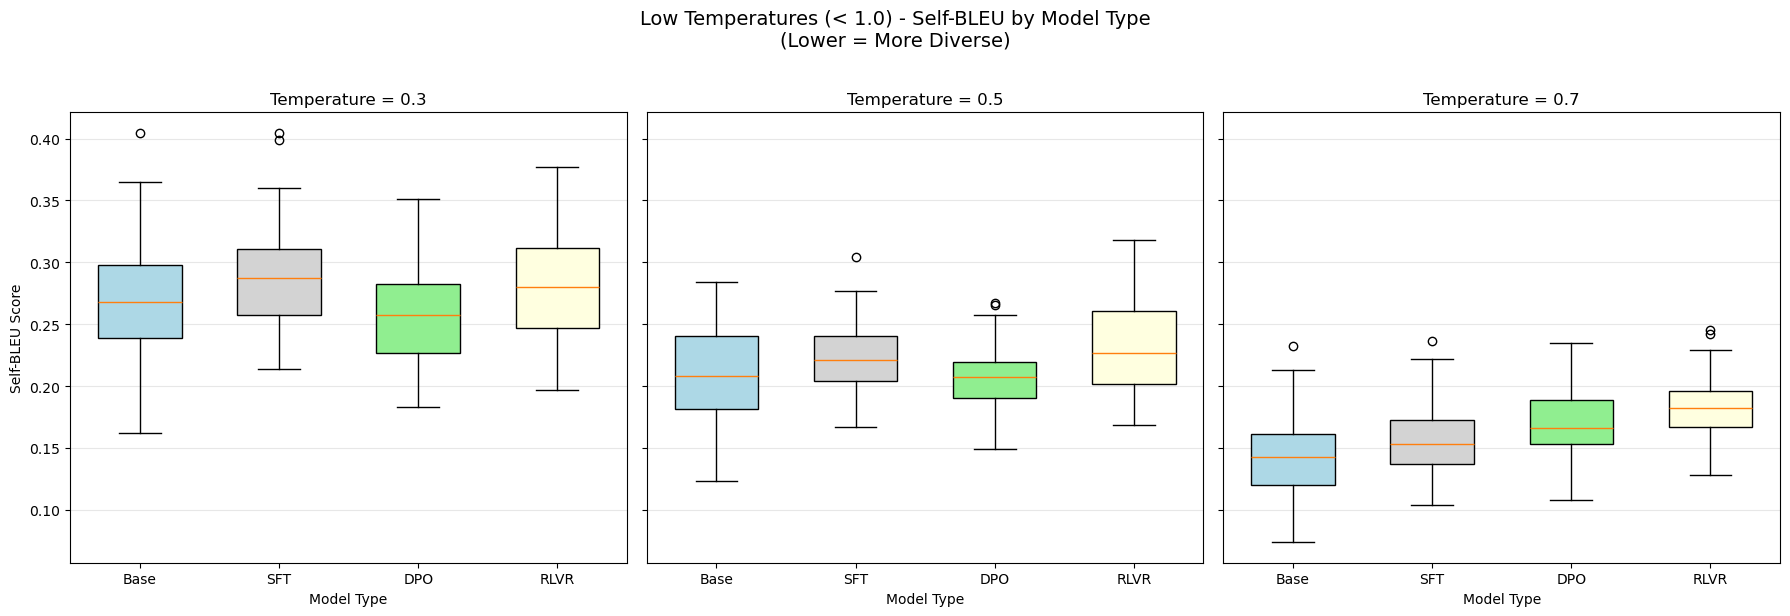

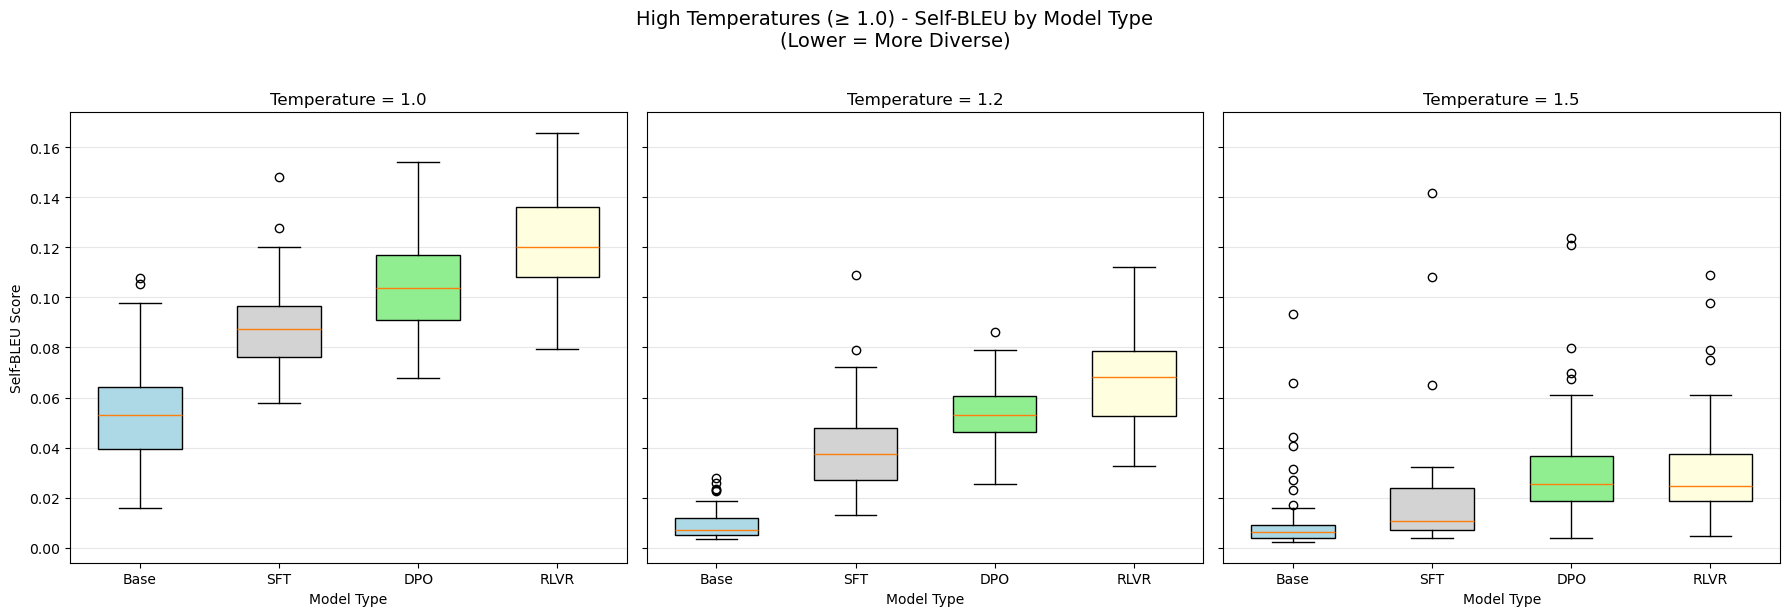


Self-BLEU Statistics by Temperature and Model:

Temperature: 0.3
BASE  : n=  50, mean=0.2703, std=0.0511, min=0.1617, max=0.4046
SFT   : n=  50, mean=0.2890, std=0.0424, min=0.2134, max=0.4044
DPO   : n=  50, mean=0.2600, std=0.0394, min=0.1827, max=0.3508
RLVR  : n=  50, mean=0.2820, std=0.0475, min=0.1970, max=0.3771

Temperature: 0.5
BASE  : n=  50, mean=0.2101, std=0.0372, min=0.1234, max=0.2837
SFT   : n=  50, mean=0.2213, std=0.0283, min=0.1673, max=0.3046
DPO   : n=  50, mean=0.2071, std=0.0273, min=0.1491, max=0.2674
RLVR  : n=  50, mean=0.2334, std=0.0384, min=0.1684, max=0.3182

Temperature: 0.7
BASE  : n=  50, mean=0.1440, std=0.0378, min=0.0738, max=0.2323
SFT   : n=  50, mean=0.1564, std=0.0310, min=0.1040, max=0.2367
DPO   : n=  50, mean=0.1681, std=0.0266, min=0.1076, max=0.2350
RLVR  : n=  50, mean=0.1839, std=0.0264, min=0.1278, max=0.2453

Temperature: 1.0
BASE  : n=  50, mean=0.0547, std=0.0202, min=0.0158, max=0.1076
SFT   : n=  50, mean=0.0879, std=0.0168, min=0.0

In [5]:
# Visualize self-BLEU scores by model and temperature

# Split temperatures into low and high groups
low_temps = [t for t in bleu_df['temperature'].unique() if t < 1.0]
high_temps = [t for t in bleu_df['temperature'].unique() if t >= 1.0]

low_temps.sort()
high_temps.sort()

def plot_bleu_by_temp_group(temps, title_prefix):
    n_temps = len(temps)
    fig, axes = plt.subplots(1, n_temps, figsize=(6*n_temps, 6), sharey=True)
    
    if n_temps == 1:
        axes = [axes]
    
    for temp_idx, temp in enumerate(temps):
        ax = axes[temp_idx]
        
        # Filter data for this temperature
        temp_data = bleu_df[bleu_df['temperature'] == temp]
        
        # Collect BLEU data for each model
        bleu_by_model = []
        for model in model_types:
            model_data = temp_data[temp_data['model_key'] == model]
            bleu_by_model.append(model_data['self_bleu'].tolist())
        
        # Create box plot
        positions = list(range(len(model_types)))
        bp = ax.boxplot(bleu_by_model, positions=positions, widths=0.6, patch_artist=True)
        
        # Color each box
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        
        ax.set_xlabel('Model Type')
        if temp_idx == 0:
            ax.set_ylabel('Self-BLEU Score')
        ax.set_title(f'Temperature = {temp:.1f}')
        ax.set_xticks(positions)
        ax.set_xticklabels(['Base', 'SFT', 'DPO', 'RLVR'])
        ax.grid(axis='y', alpha=0.3)
    
    plt.suptitle(f'{title_prefix} - Self-BLEU by Model Type\n(Lower = More Diverse)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# Plot low temperatures
plot_bleu_by_temp_group(low_temps, 'Low Temperatures (< 1.0)')

# Plot high temperatures  
plot_bleu_by_temp_group(high_temps, 'High Temperatures (≥ 1.0)')

# Print detailed statistics
print("\nSelf-BLEU Statistics by Temperature and Model:")
for temp in sorted(bleu_df['temperature'].unique()):
    print(f"\n{'='*60}")
    print(f"Temperature: {temp:.1f}")
    print(f"{'='*60}")
    temp_data = bleu_df[bleu_df['temperature'] == temp]
    
    for model_key in model_types:
        model_data = temp_data[temp_data['model_key'] == model_key]
        bleu_scores = model_data['self_bleu']
        
        if len(bleu_scores) > 0:
            print(f"{model_key.upper():6s}: n={len(bleu_scores):4d}, mean={bleu_scores.mean():.4f}, "
                  f"std={bleu_scores.std():.4f}, min={bleu_scores.min():.4f}, max={bleu_scores.max():.4f}")
        else:
            print(f"{model_key.upper():6s}: No data")

## Gender distribution over all responses

Now extract the assumed gender across all responses per model, and later per temperature.

In [12]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True, nb_workers=8)

def remove_preamble(text):
    import re
    pattern = r'.*?(?:assistant\s*)?.*?Assuming the individual is\s*(.*)'
    match = re.search(pattern, text, re.DOTALL | re.IGNORECASE)
    if match:
        return match.group(1).strip()
    return text

olmo_df['response'] = olmo_df['response'].parallel_apply(remove_preamble)


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [19]:

def assign_gender(model_response):
    response = model_response.lower()
    first_few_words = ' '.join(response.split()[:100])
    female_indicators = ['female', 'woman']
    male_indicators = ['male', 'man']   
    unassigned = ['gender', '[gender]']
    for indicator in female_indicators:
        if indicator in first_few_words:
            return 'female'
    for indicator in male_indicators:
        if indicator in first_few_words:
            return 'male'
    for indicator in unassigned:
        if indicator in first_few_words:
            return 'gender'
    return 'None'

olmo_df['gender_assignment'] = olmo_df['response'].parallel_apply(assign_gender)
olmo_df.head()

,model_key,model_name,profile_id,response_number,response,temperature,entropy_mean_entropy,entropy_max_entropy,entropy_min_entropy,entropy_std_entropy,gender_assignment
0,base,allenai/Olmo-3-1025-7B,1,1,"[gender], their name is [name]. This narrativ...",0.7,0.839428,3.03125,3.408641e-07,0.742685,gender
1,base,allenai/Olmo-3-1025-7B,1,2,"female, her name is [name], and she is a 30-y...",0.7,0.729715,2.93750,2.682209e-07,0.705402,female
2,base,allenai/Olmo-3-1025-7B,1,3,"female, [Gender: Female], [Education Level: L...",0.7,0.852306,2.90625,1.430511e-06,0.720453,female
3,base,allenai/Olmo-3-1025-7B,1,4,"male and naming him as John, the following na...",0.7,0.979604,3.65625,7.338822e-07,0.789281,male
4,base,allenai/Olmo-3-1025-7B,1,5,"female, her name is Sofia, and she is a low-e...",0.7,0.781961,2.62500,5.140901e-07,0.661650,female


In [20]:
olmo_df['gender_assignment'].value_counts(dropna=False)

gender_assignment
female    2938
male      2514
None       326
gender     221
Name: count, dtype: int64

In [21]:
# Create a comprehensive breakdown of gender assignments by model and temperature
print("Gender Assignment Breakdown by Model and Temperature")
print("="*80)

for model in model_types:
    print(f"\n{model.upper()}")
    print("-"*80)
    
    model_data = olmo_df[olmo_df['model_key'] == model]
    
    for temp in sorted(olmo_df['temperature'].unique()):
        temp_model_data = model_data[model_data['temperature'] == temp]
        
        print(f"\n  Temperature: {temp:.1f}")
        print(f"  {'-'*40}")
        
        gender_counts = temp_model_data['gender_assignment'].value_counts(dropna=False)
        total = len(temp_model_data)
        
        for gender, count in gender_counts.items():
            percentage = (count / total) * 100
            print(f"    {str(gender):10s}: {count:4d} ({percentage:5.1f}%)")
        
        print(f"    {'Total':10s}: {total:4d}")

Gender Assignment Breakdown by Model and Temperature

BASE
--------------------------------------------------------------------------------

  Temperature: 0.3
  ----------------------------------------
    female    :  179 ( 71.9%)
    male      :   46 ( 18.5%)
    gender    :   24 (  9.6%)
    Total     :  249

  Temperature: 0.5
  ----------------------------------------
    female    :  146 ( 58.4%)
    male      :   57 ( 22.8%)
    gender    :   47 ( 18.8%)
    Total     :  250

  Temperature: 0.7
  ----------------------------------------
    female    :  126 ( 50.4%)
    male      :   81 ( 32.4%)
    gender    :   43 ( 17.2%)
    Total     :  250

  Temperature: 1.0
  ----------------------------------------
    female    :  129 ( 51.6%)
    male      :   70 ( 28.0%)
    gender    :   45 ( 18.0%)
    None      :    6 (  2.4%)
    Total     :  250

  Temperature: 1.2
  ----------------------------------------
    female    :  118 ( 47.2%)
    male      :   91 ( 36.4%)
    gender 


BASE - Gender counts by temperature:
gender_assignment  None  female  gender  male
temperature                                  
0.3                   0     179      24    46
0.5                   0     146      47    57
0.7                   0     126      43    81
1.0                   6     129      45    70
1.2                   8     118      33    91
1.5                  40     105      11    94
Column totals: {'None': 54, 'female': 803, 'gender': 203, 'male': 439}

SFT - Gender counts by temperature:
gender_assignment  None  female  gender  male
temperature                                  
0.3                   0     119       0   131
0.5                   0     121       0   129
0.7                   0     132       0   118
1.0                   3     126       6   115
1.2                  34     105       6   105
1.5                  90      27       0   133
Column totals: {'None': 127, 'female': 630, 'gender': 12, 'male': 731}

DPO - Gender counts by temperature:
gender_ass

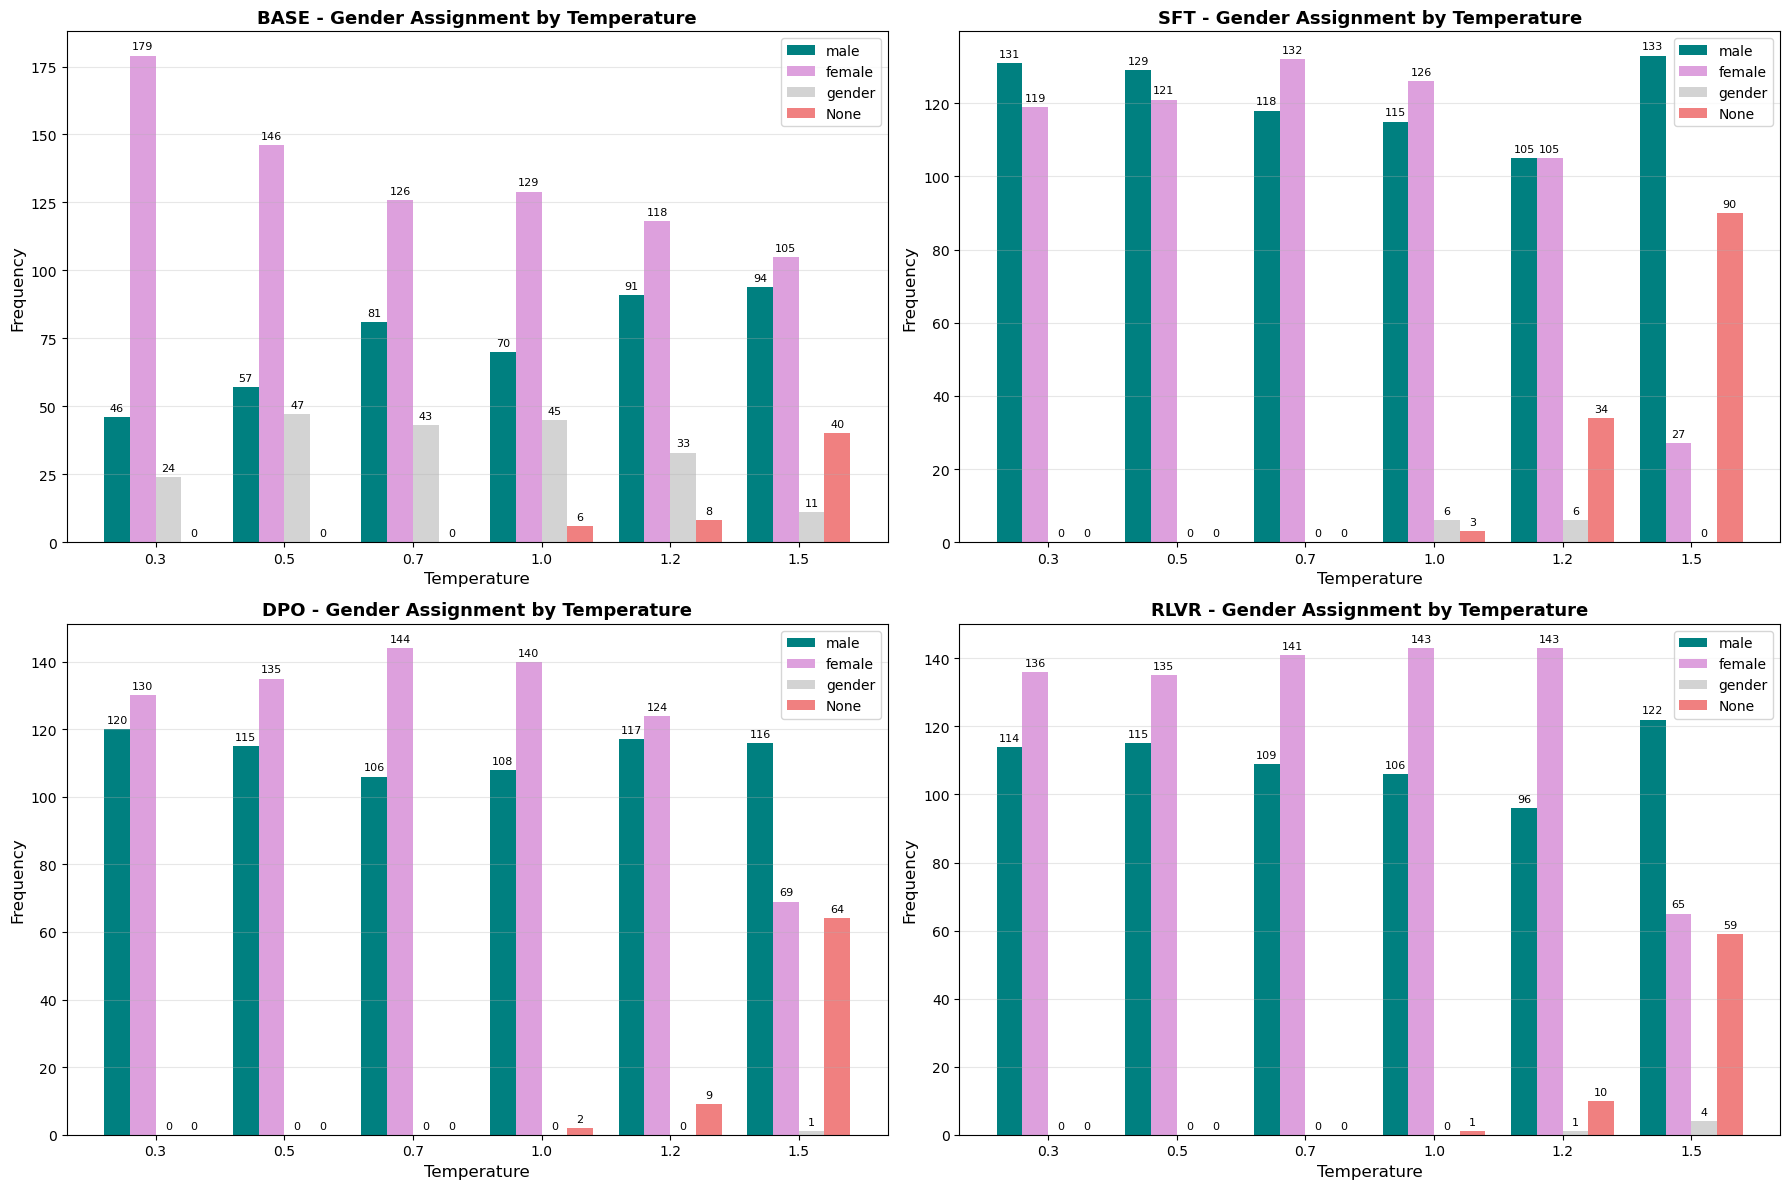

In [23]:
# Create a plot showing all gender assignment counts by temperature for each model
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

# Define colors for each category
category_colors = {
    'male': 'teal',
    'female': 'plum',
    'gender': 'lightgray',
    'None': 'lightcoral'
}

for idx, model in enumerate(model_types):
    ax = axes[idx]
    
    model_data = olmo_df[olmo_df['model_key'] == model]
    
    # Get counts by temperature and gender (including all values)
    temp_gender_counts = model_data.groupby(['temperature', 'gender_assignment'], dropna=False).size().unstack(fill_value=0)
    
    # Sort by temperature
    temp_gender_counts = temp_gender_counts.sort_index()
    
    # Determine which categories are present
    all_categories = ['male', 'female', 'gender', 'None']
    present_categories = [cat for cat in all_categories if cat in temp_gender_counts.columns]
    
    # Plot
    x = np.arange(len(temp_gender_counts.index))
    n_categories = len(present_categories)
    width = 0.8 / n_categories  # Adjust width based on number of categories
    
    bars_list = []
    for i, category in enumerate(present_categories):
        offset = (i - n_categories/2 + 0.5) * width
        counts = temp_gender_counts[category]
        color = category_colors.get(category, 'lightblue')
        label = str(category) #if category is not None else 'None'
        bars = ax.bar(x + offset, counts, width, label=label, color=color)
        bars_list.append(bars)
        
        # Add count labels on bars
        ax.bar_label(bars, padding=3, fontsize=8)
    
    ax.set_xlabel('Temperature', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'{model.upper()} - Gender Assignment by Temperature', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{t:.1f}' for t in temp_gender_counts.index])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Print statistics
    print(f"\n{model.upper()} - Gender counts by temperature:")
    print(temp_gender_counts)
    print(f"Column totals: {temp_gender_counts.sum().to_dict()}")

plt.tight_layout()
plt.show()


BASE:
  Total responses: 1499
  female    :  803 ( 53.6%)
  male      :  439 ( 29.3%)
  gender    :  203 ( 13.5%)
  None      :   54 (  3.6%)

SFT:
  Total responses: 1500
  male      :  731 ( 48.7%)
  female    :  630 ( 42.0%)
  None      :  127 (  8.5%)
  gender    :   12 (  0.8%)

DPO:
  Total responses: 1500
  female    :  742 ( 49.5%)
  male      :  682 ( 45.5%)
  None      :   75 (  5.0%)
  gender    :    1 (  0.1%)

RLVR:
  Total responses: 1500
  female    :  763 ( 50.9%)
  male      :  662 ( 44.1%)
  None      :   70 (  4.7%)
  gender    :    5 (  0.3%)


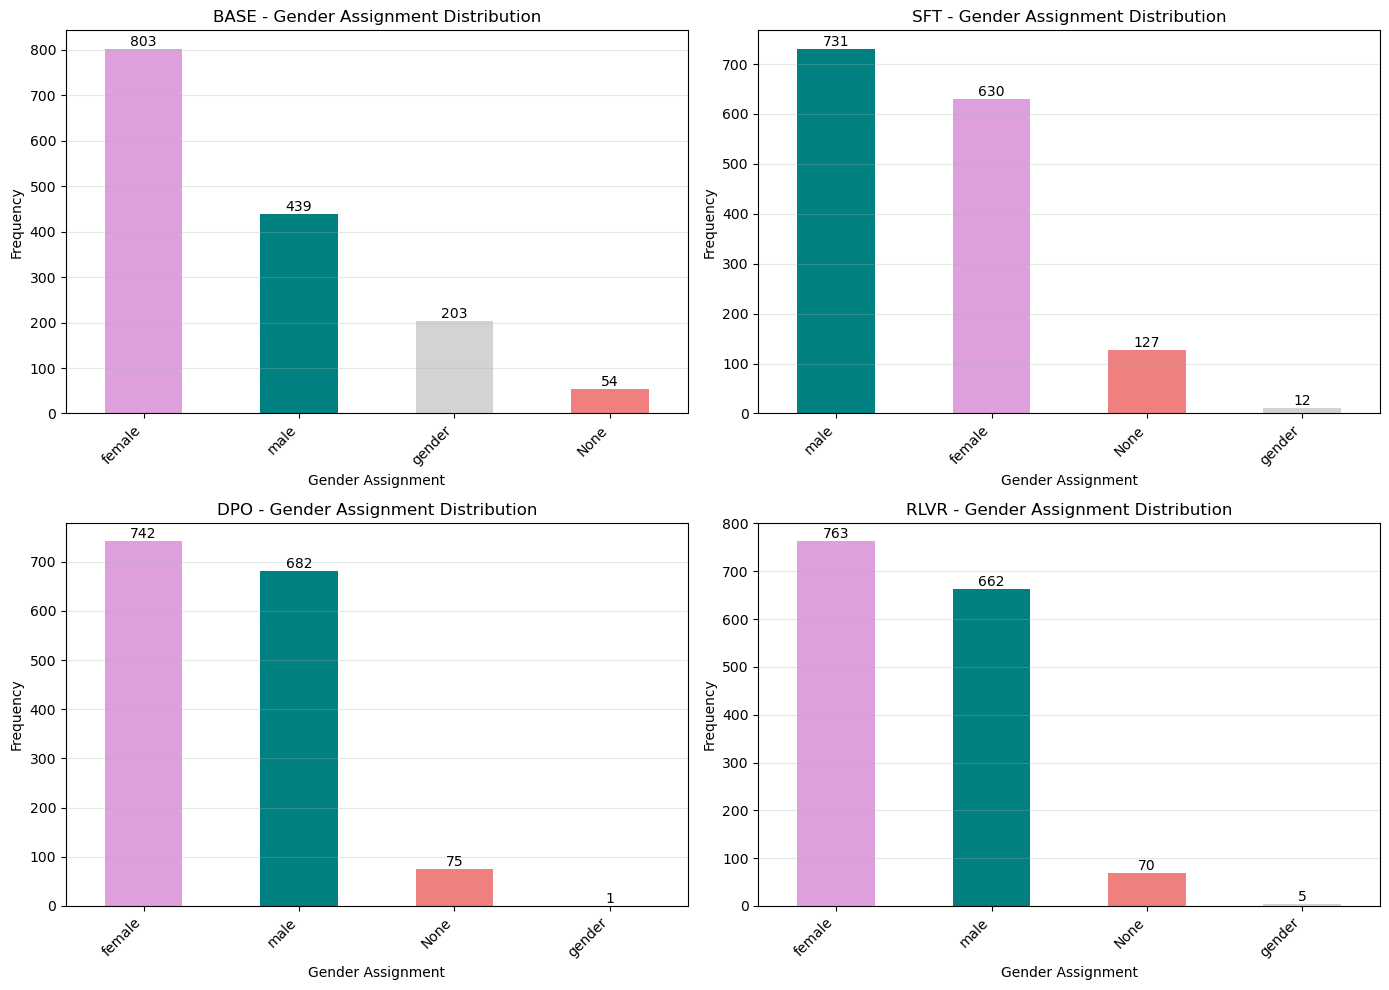

In [24]:
# Create subplots for gender assignment frequency by model
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Define colors for different categories
color_map = {
    'female': 'plum',
    'male': 'teal',
    'gender': 'lightgray',
    'None': 'lightcoral'
}

for idx, model in enumerate(model_types):
    model_data = olmo_df[olmo_df['model_key'] == model]
    
    # Count all gender assignments (including None)
    gender_counts = model_data['gender_assignment'].value_counts(dropna=False)
    
    # Assign colors based on the category
    colors = [color_map.get(cat, 'lightblue') for cat in gender_counts.index]
    
    # Create bar plot
    gender_counts.plot(kind='bar', ax=axes[idx], color=colors)
    axes[idx].set_title(f'{model.upper()} - Gender Assignment Distribution')
    axes[idx].set_xlabel('Gender Assignment')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add count labels on bars
    for container in axes[idx].containers:
        axes[idx].bar_label(container)
    
    # Print detailed statistics
    total_responses = len(model_data)
    print(f"\n{model.upper()}:")
    print(f"  Total responses: {total_responses}")
    for category, count in gender_counts.items():
        percentage = (count / total_responses) * 100
        print(f"  {str(category):10s}: {count:4d} ({percentage:5.1f}%)")

plt.tight_layout()
plt.show()